In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Go to root dir
sys.path.append(os.path.abspath(".."))

from src.load_data import load_sheet, clean_sheet

In [2]:
np.random.seed(42)

In [3]:
internal_df, sheet1 = load_sheet("Electroplate Experiments Data JUN_JUL", "vary_internal_table")
internal_df = clean_sheet(internal_df)
# two_side_plate, sheet2 = load_sheet("Electroplate Experiments Data JUN_JUL", "2 side Experimental Result")
# two_side_plate = clean_sheet(two_side_plate)
august_df, sheet3 = load_sheet("Electroplating Experiments Data August", "Sheet1")
august_df = clean_sheet(august_df)
september_df, sheet4 = load_sheet("Electroplating Experiments Data September", "Sheet1")
september_df =clean_sheet(september_df)

In [4]:
df = pd.concat([internal_df, august_df, september_df])

In [5]:
df.run_id.unique()

array(['JUL_3_1', 'JUL_3_2', 'JUL_3_3', 'JUL_3_4', 'JUL_7_1', 'JUL_7_2',
       'JUL_7_3', 'JUL_7_4', 'JUL_8_1', 'JUL_8_2', 'JUL_8_3', 'JUL_8_4',
       'JUL_9_1', 'JUL_9_2', 'JUL_16_1', 'JUL_16_2', 'JUL_16_3',
       'JUL_16_4', 'JUL_16_5', 'JUL_16_6', 'JUL_17_1', 'JUL_17_2',
       'JUL_17_3', 'JUL_17_4', 'JUL_17_5', 'JUL_17_6', 'JUL_17_7',
       'JUL_21_1', 'JUL_21_2', 'JUL_21_3', 'JUL_21_4', 'JUL_22_1',
       'JUL_22_2', 'JUL_22_3', 'JUL_22_4', 'JUL_22_5', 'JUL_22_6',
       'JUL_22_7', 'JUL_22_8', 'JUL_22_9', 'JUL_23_1', 'JUL_23_2',
       'JUL_23_3', 'JUL_23_4', 'JUL_23_5', 'JUL_24_1', 'JUL_24_2',
       'JUL_24_3', 'JUL_24_4', 'JUL_24_5', 'JUL_24_6', 'JUL_24_7',
       'JUL_24_8', 'JUL_24_9', 'JUL_24_10', 'JUL_31_1', 'JUL_31_2',
       'JUL_31_3', 'JUL_31_4', 'JUL_31_5', 'JUL_31_6', 'AUG_6_1',
       'AUG_6_2', 'AUG_7_1', 'AUG_7_2', 'AUG_7_3', 'AUG_7_4', 'AUG_7_5',
       'AUG_7_6', 'SEPT_24_1', 'SEPT_24_2', 'SEPT_25_1', 'SEPT_25_2',
       'SEPT_25_3', 'SEPT_25_4', 'SEPT_25_5

In [6]:
# ---------------------------------------------
# 1. Custom Transformer: Select Specific Columns
# ---------------------------------------------
class FeatureSelector(BaseEstimator, TransformerMixin):
	def __init__(self, feature_names):
		self.feature_names = feature_names
	
	def fit(self, X, y=None):
		return self

	def transform(self, X):
		return X[self.feature_names]

In [7]:
SENSOR_FEATURES = ["conductivity", "temperature", "pH",	"voltage"]
TRAIN_RUNS = ['JUL_22_1','JUL_22_2', 'JUL_22_3', 'JUL_22_4', 'JUL_22_5', 'JUL_22_6','JUL_22_7', 'JUL_22_8', 'JUL_22_9', 
			  'JUL_23_1', 'JUL_23_2', 'JUL_23_3', 'JUL_23_4', 'JUL_23_5']
TEST_RUNS = ['JUL_24_1', 'JUL_24_2',
       'JUL_24_3', 'JUL_24_4', 'JUL_24_5', 'JUL_24_6', 'JUL_24_7',
       'JUL_24_8', 'JUL_24_9', 'JUL_24_10']
window_size = 5

In [8]:
df_train = df[df['run_id'].isin(TRAIN_RUNS)].reset_index(drop=True)
df_train

,run_id,mass_SLS,mass_NISO4,mass_NICL2,time_total,conductivity,temperature,pH,voltage,current,amp_hour,bath_id
0,JUL_22_1,0.35,270.0,40.0,2,56.32,49.70,4.02,3.639,2.342,0.002,Bath_3
1,JUL_22_1,0.35,270.0,40.0,4,56.32,49.70,4.02,3.705,2.342,0.004,Bath_3
2,JUL_22_1,0.35,270.0,40.0,6,56.17,49.71,4.02,3.702,2.342,0.006,Bath_3
3,JUL_22_1,0.35,270.0,40.0,8,56.17,49.68,4.02,3.673,2.342,0.008,Bath_3
4,JUL_22_1,0.35,270.0,40.0,10,56.17,49.69,4.02,3.668,2.342,0.010,Bath_3
...,...,...,...,...,...,...,...,...,...,...,...,...
8365,JUL_23_5,0.35,270.0,40.0,16135,58.69,49.77,4.21,3.437,2.343,10.502,Bath_3
8366,JUL_23_5,0.35,270.0,40.0,16137,58.69,49.75,4.21,3.493,2.343,10.503,Bath_3
8367,JUL_23_5,0.35,270.0,40.0,16139,58.69,49.75,4.21,3.508,2.343,10.505,Bath_3
8368,JUL_23_5,0.35,270.0,40.0,16141,58.69,49.73,4.21,3.564,2.343,10.506,Bath_3


In [9]:
df_test = df[df['run_id'].isin(TEST_RUNS)].reset_index(drop=True)
df_test

,run_id,mass_SLS,mass_NISO4,mass_NICL2,time_total,conductivity,temperature,pH,voltage,current,amp_hour,bath_id
0,JUL_24_1,0.35,270.0,40.0,16145,56.99,49.60,4.23,3.988,2.342,10.505,Bath_3
1,JUL_24_1,0.35,270.0,40.0,16147,56.85,49.61,4.23,3.868,2.342,10.506,Bath_3
2,JUL_24_1,0.35,270.0,40.0,16149,56.99,49.60,4.22,3.893,2.342,10.507,Bath_3
3,JUL_24_1,0.35,270.0,40.0,16151,56.99,49.61,4.22,3.833,2.342,10.509,Bath_3
4,JUL_24_1,0.35,270.0,40.0,16153,56.85,49.61,4.22,3.824,2.342,10.510,Bath_3
...,...,...,...,...,...,...,...,...,...,...,...,...
5965,JUL_24_10,0.35,270.0,40.0,28075,56.58,49.98,4.27,3.928,2.678,20.881,Bath_3
5966,JUL_24_10,0.35,270.0,40.0,28077,56.74,49.98,4.27,3.937,2.678,20.882,Bath_3
5967,JUL_24_10,0.35,270.0,40.0,28079,56.74,49.97,4.27,3.901,2.678,20.890,Bath_3
5968,JUL_24_10,0.35,270.0,40.0,28081,56.60,49.98,4.27,3.889,2.678,20.885,Bath_3


In [19]:
pipeline = Pipeline([
	('selector', FeatureSelector(SENSOR_FEATURES)),
	('scaler', StandardScaler()),
	('OneClassSVM', OneClassSVM(kernel='linear', gamma='scale', nu=0.5))
])

In [11]:
pipeline.fit(df_train)

,steps,"[('selector', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,feature_names,"['conductivity', 'temperature', ...]"
,copy,True
,with_mean,True
,with_std,True
,kernel,'poly'
,degree,3
,gamma,'scale'


In [12]:
# ---------------------------------------------
# 5. Apply Pipeline to All Data
# ---------------------------------------------
# Predict anomalies on full dataset
predictions = pipeline.predict(df_test)
# Add predictions to original DataFrame
df_test['anomaly'] = predictions
df_test['is_anomaly'] = df_test['anomaly'] == -1  # -1 = anomaly, 1 = normal

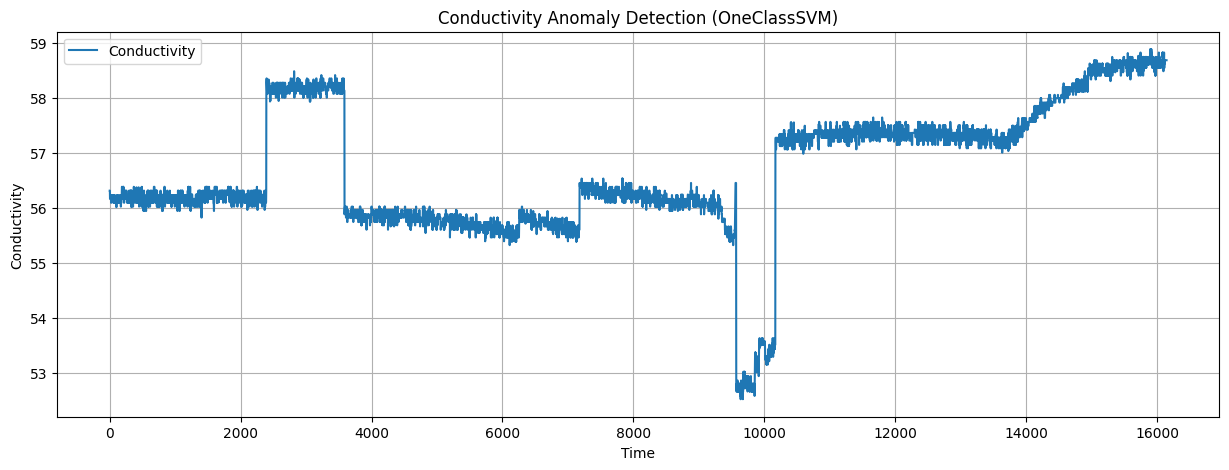

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(df_train['time_total'], df_train['conductivity'], label='Conductivity')
# plt.scatter(df_train[df_train['is_anomaly']]['time_total'], df_train[df_train['is_anomaly']]['conductivity'],
#             color='red', label='Anomalies', s=10)
plt.xlabel("Time")
plt.ylabel("Conductivity")
plt.title("Conductivity Anomaly Detection (OneClassSVM)")
plt.legend()
plt.grid(True)

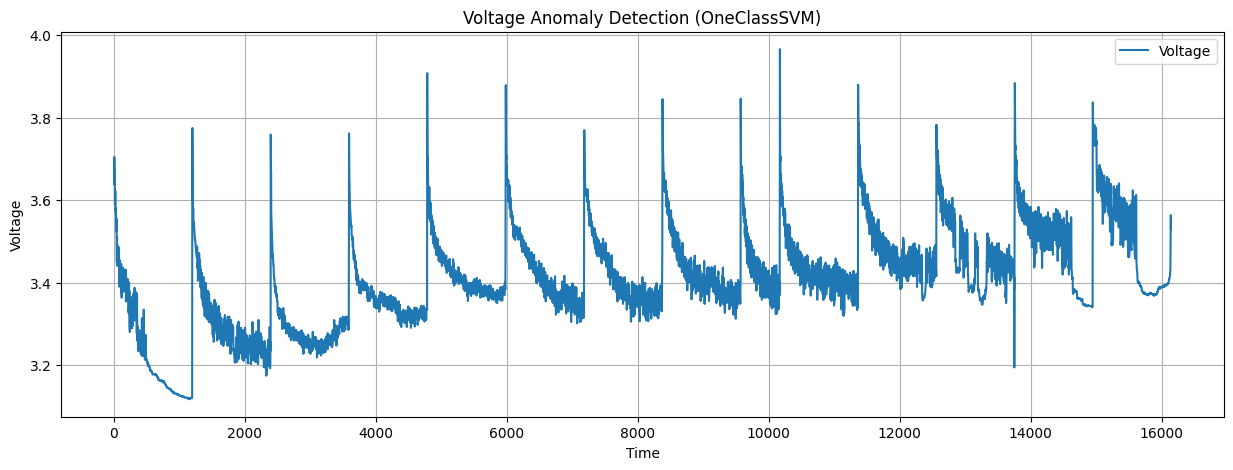

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(df_train['time_total'], df_train['voltage'], label='Voltage')
plt.xlabel("Time")
plt.ylabel("Voltage")
plt.title("Voltage Anomaly Detection (OneClassSVM)")
plt.legend()
plt.grid(True)

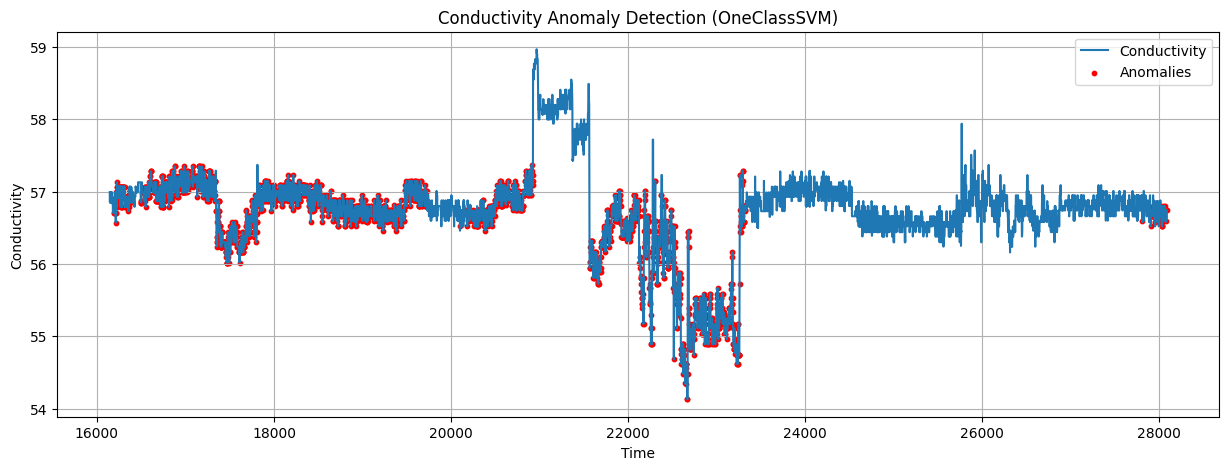

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(df_test['time_total'], df_test['conductivity'], label='Conductivity')
plt.scatter(df_test[df_test['is_anomaly']]['time_total'], df_test[df_test['is_anomaly']]['conductivity'],
            color='red', label='Anomalies', s=10)
plt.xlabel("Time")
plt.ylabel("Conductivity")
plt.title("Conductivity Anomaly Detection (OneClassSVM)")
plt.legend()
plt.grid(True)
plt.show()

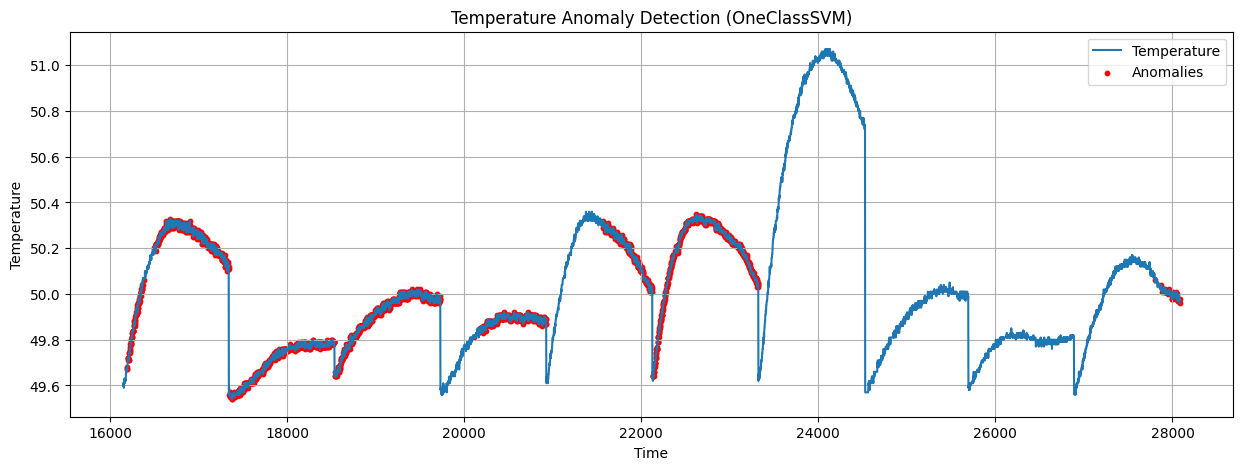

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(df_test['time_total'], df_test['temperature'], label='Temperature')
plt.scatter(df_test[df_test['is_anomaly']]['time_total'], df_test[df_test['is_anomaly']]['temperature'],
            color='red', label='Anomalies', s=10)
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.title("Temperature Anomaly Detection (OneClassSVM)")
plt.legend()
plt.grid(True)
plt.show()

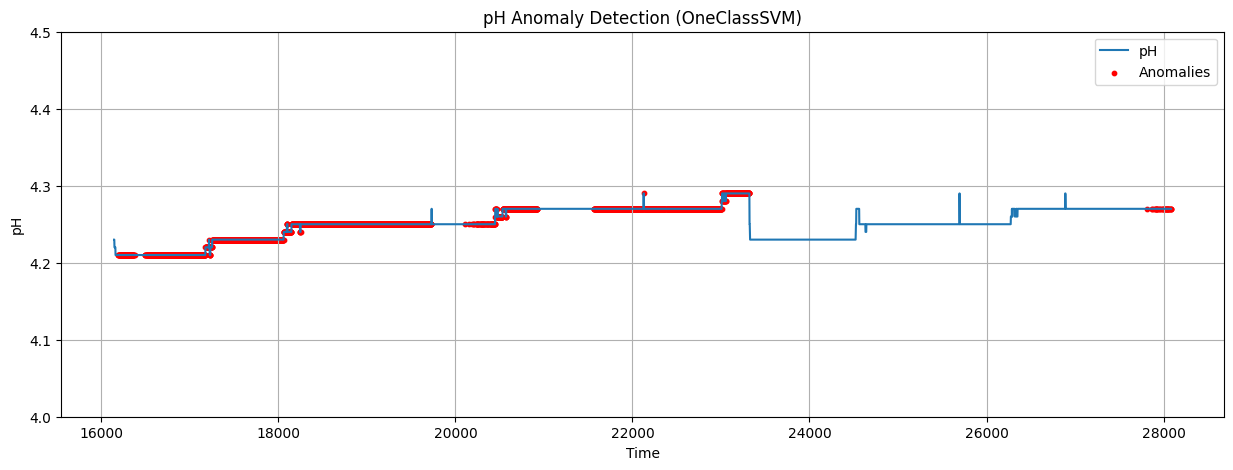

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(df_test['time_total'], df_test['pH'], label='pH')
plt.scatter(df_test[df_test['is_anomaly']]['time_total'], df_test[df_test['is_anomaly']]['pH'],
            color='red', label='Anomalies', s=10)
plt.xlabel("Time")
plt.ylabel("pH")
plt.title("pH Anomaly Detection (OneClassSVM)")
plt.ylim((4.0, 4.5))
plt.legend()
plt.grid(True)
plt.show()

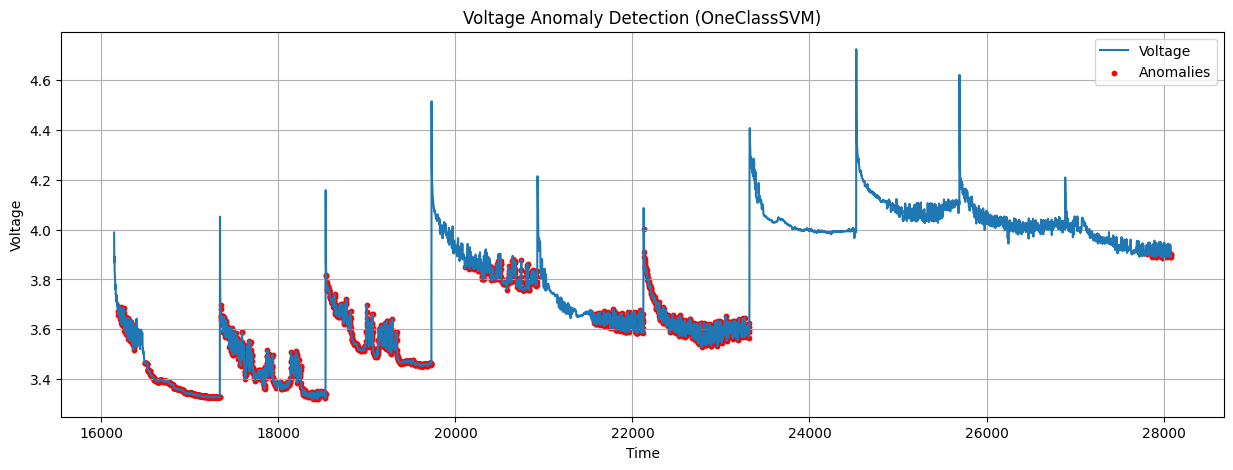

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(df_test['time_total'], df_test['voltage'], label='Voltage')
plt.scatter(df_test[df_test['is_anomaly']]['time_total'], df_test[df_test['is_anomaly']]['voltage'],
            color='red', label='Anomalies', s=10)
plt.xlabel("Time")
plt.ylabel("Voltage")
plt.title("Voltage Anomaly Detection (OneClassSVM)")
plt.legend()
plt.grid(True)
plt.show()